# Fast G-Factor Calculation

## Simulate Data

In [20]:
import torch
import matplotlib.pyplot as plt
import time
from mr_recon.dtypes import complex_dtype, real_dtype
from mr_recon.gfactor import gfactor_SENSE_diag, gfactor_SENSE_PMR,calc_variance_PMR,diagonal_estimator
from mr_recon.algs import conjugate_gradient, density_compensation
from mr_recon.fourier import sigpy_nufft
from mr_recon.linops import sense_linop, batching_params
from mr_recon.recons import CG_SENSE_recon
from mr_recon.utils import np_to_torch, gen_grd, normalize
from mr_recon.calib import calc_coil_subspace
from mr_recon.iqa import compare_g_factors
from mr_recon.phantoms import shepp_logan
from mr_recon.grad_utils import design_spiral_trj
from typing import Optional
from tqdm import tqdm
import numpy as np
import os

In [50]:
# --- Configuration ---
data_dir = "brain_data"
R = 3  # Acceleration factor (e.g., R=2 means keep 1 out of every 2 shots)

# Device and dtype
torch_dev = torch.device("cuda:0")
complex_dtype = torch.complex64

# Load data from .pt files
mps_torch = torch.load(os.path.join(data_dir, "mps.pt"))
ksp_torch_full = torch.load(os.path.join(data_dir, "ksp.pt")) # Load full k-space
dcf_torch_full = torch.load(os.path.join(data_dir, "dcf.pt")) # Load full dcf
trj_torch_full = torch.load(os.path.join(data_dir, "trj.pt")) # Load full trajectory

# Convert to appropriate device and dtype
mps_torch = mps_torch.to(device=torch_dev, dtype=complex_dtype)
ksp_torch_full = ksp_torch_full.to(device=torch_dev, dtype=complex_dtype)
dcf_torch_full = dcf_torch_full.to(device=torch_dev, dtype=torch.float32)
trj_torch_full = trj_torch_full.to(device=torch_dev, dtype=torch.float32)

print("Data moved to target device and dtypes set.")
print(f"  mps shape: {mps_torch.shape}")
print(f"  ksp_full shape: {ksp_torch_full.shape}")
print(f"  dcf_full shape: {dcf_torch_full.shape}")
print(f"  trj_full shape: {trj_torch_full.shape}")


# --- Retrospective Undersampling ---
# Determine number of shots and samples per shot
num_shots_total = trj_torch_full.shape[1]  # Assuming shots are in dimension 1
samples_per_shot = trj_torch_full.shape[0]  # Assuming samples are in dimension 0
print(f"Data structure confirmed: {num_shots_total} shots, {samples_per_shot} samples/shot.")

# Generate indices for the shots to keep
shots_to_keep = torch.arange(0, num_shots_total, R, device=torch_dev)
num_shots_recon = len(shots_to_keep)
print(f"Using R={R}, selecting shots: {shots_to_keep.cpu().numpy()}")

# Select the undersampled data based on the SHOT dimension
trj_torch_acc_shots = trj_torch_full[:, shots_to_keep, :] # Shape: [S, N_kept, D]
dcf_torch_acc_shots = dcf_torch_full[:, shots_to_keep]    # Shape: [S, N_kept]
ksp_torch_acc_shots = ksp_torch_full[:, :, shots_to_keep] # Shape: [C, S, N_kept]

# --- Reshape Data for NUFFT/SENSE (Flatten SamplesPerShot and Shots dims) ---
C = ksp_torch_acc_shots.shape[0]
D = trj_torch_acc_shots.shape[2]

# Reshape KSP: [C, S, N_kept] -> [C, S * N_kept]
ksp_acc = ksp_torch_acc_shots.reshape(C, -1).contiguous()

# Reshape DCF: [S, N_kept] -> [S * N_kept]
dcf_acc = dcf_torch_acc_shots.reshape(-1).contiguous()

# Reshape TRJ: [S, N_kept, D] -> [S * N_kept, D]
# NOTE: sense_linop might expect [D, S*N_kept]. Adjust transpose if needed.
# The user output specified [S*N_kept, D]
trj_acc = trj_torch_acc_shots.reshape(-1, D).contiguous()

print("\nData after undersampling and reshaping:")
print(f"  ksp_acc shape: {ksp_acc.shape}")
print(f"  dcf_acc shape: {dcf_acc.shape}")
print(f"  trj_acc shape: {trj_acc.shape}")

# --- Coil Compression (applied to original maps) ---
# Assuming calc_coil_subspace is defined elsewhere
C_orig = mps_torch.shape[0]
# _, mps_torch = calc_coil_subspace(mps_torch, 0.95, mps_torch)
C_compressed = mps_torch.shape[0]
print(f"\nCoil compression applied. Original coils: {C_orig}, Compressed coils: {C_compressed} (threshold: {0.95})")

# --- Construct the SENSE Operator for *Accelerated* Data ---
im_size = tuple(mps_torch.shape[-2:])
C = mps_torch.shape[0]
print(f"\nDetermined image size: {im_size}, Number of coils: {C}")

# Create an NUFFT operator
# Assuming sigpy_nufft is defined elsewhere
nufft_width = 4
nufft = sigpy_nufft(im_size, width=nufft_width)
print(f"NUFFT operator created with width={nufft_width}.")

# Set batching parameters
# Assuming batching_params is defined elsewhere
bparams = batching_params(C)
print("Batching parameters set.")

# Create the SENSE operator using the ACCELERATED (and reshaped) trajectory and dcf
# Assuming sense_linop is defined elsewhere
A_acc = sense_linop(im_size, trj_acc, mps_torch, dcf_acc, nufft,
                    bparams=bparams, use_toeplitz=True) # Adjust parameters if needed
print(f"SENSE operator 'A_acc' created successfully for R={R} acceleration.")

# --- Optional: Define operator for fully sampled data ---
# Reshape original data first if needed by sense_linop
ksp_torch_full_flat = ksp_torch_full.reshape(ksp_torch_full.shape[0], -1).contiguous()
dcf_torch_full_flat = dcf_torch_full.reshape(-1).contiguous()
trj_torch_full_flat = trj_torch_full.reshape(-1, trj_torch_full.shape[2]).contiguous()
A = sense_linop(im_size, trj_torch_full_flat, mps_torch, dcf_torch_full_flat, nufft,
                bparams=bparams, use_toeplitz=True)
print("SENSE operator 'A' for fully sampled data also created (optional).")


Data moved to target device and dtypes set.
  mps shape: torch.Size([32, 220, 220])
  ksp_full shape: torch.Size([32, 3519, 16])
  dcf_full shape: torch.Size([3519, 16])
  trj_full shape: torch.Size([3519, 16, 2])
Data structure confirmed: 16 shots, 3519 samples/shot.
Using R=3, selecting shots: [ 0  3  6  9 12 15]

Data after undersampling and reshaping:
  ksp_acc shape: torch.Size([32, 21114])
  dcf_acc shape: torch.Size([21114])
  trj_acc shape: torch.Size([21114, 2])

Coil compression applied. Original coils: 32, Compressed coils: 32 (threshold: 0.95)

Determined image size: (220, 220), Number of coils: 32
NUFFT operator created with width=4.
Batching parameters set.
SENSE operator 'A_acc' created successfully for R=3 acceleration.
SENSE operator 'A' for fully sampled data also created (optional).


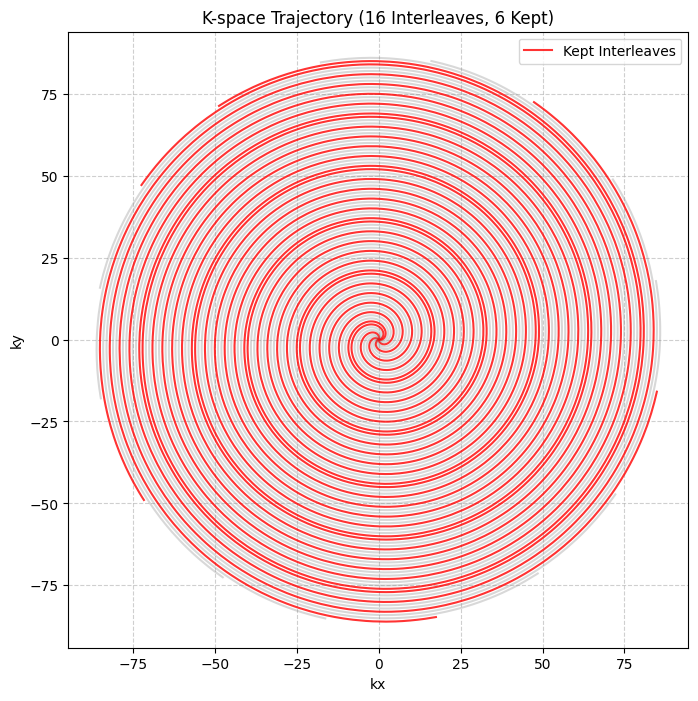

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure trj_torch_full and shots_to_keep are defined and on the CPU for plotting
if 'trj_torch_full' in locals() or 'trj_torch_full' in globals():
    trj_np = trj_torch_full.cpu().numpy() # Move to CPU and convert to NumPy
    num_samples, num_interleaves, num_dims = trj_np.shape

    if 'shots_to_keep' in locals() or 'shots_to_keep' in globals():
        # Ensure shots_to_keep is on CPU and is a NumPy array for efficient checking
        shots_to_keep_np = shots_to_keep.cpu().numpy()

        if num_dims == 2: # Check if it's 2D trajectory data
            plt.figure(figsize=(8, 8))
            # Update title to show how many were kept
            plt.title(f'K-space Trajectory ({num_interleaves} Interleaves, {len(shots_to_keep_np)} Kept)')

            kept_legend_added = False # Flag to add legend entry only once

            # Plot all interleaves
            for i in range(num_interleaves):
                if i in shots_to_keep_np:
                    # Plot kept interleaves in red
                    label = 'Kept Interleaves' if not kept_legend_added else None
                    plt.plot(trj_np[:, i, 0], trj_np[:, i, 1], color='red', alpha=0.8, label=label)
                    kept_legend_added = True
                else:
                    # Plot discarded interleaves in grey with lower alpha
                    plt.plot(trj_np[:, i, 0], trj_np[:, i, 1], color='grey', alpha=0.3)

            plt.xlabel('kx')
            plt.ylabel('ky')
            if kept_legend_added: # Only add legend if some interleaves were kept
                plt.legend()
            plt.axis('equal') # Ensure aspect ratio is equal
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
        else:
            print(f"Trajectory has {num_dims} dimensions. Visualization is set up for 2D (kx, ky).")
    else:
         print("Error: 'shots_to_keep' not found. Please ensure it's defined from the undersampling step.")

else:
    print("Error: 'trj_torch_full' not found. Please ensure it's loaded.")



Starting reconstruction for R=3 (Accelerated)...
AHb took 0.018(s)


CG Iterations:   9%|▉         | 9/100 [00:00<00:00, 175.51it/s]


Accelerated reconstruction finished.

Starting reconstruction for Reference (Fully Sampled)...
AHb took 0.004(s)


CG Iterations:   9%|▉         | 9/100 [00:00<00:00, 178.71it/s]

Reference reconstruction finished.

Displaying reconstructions...


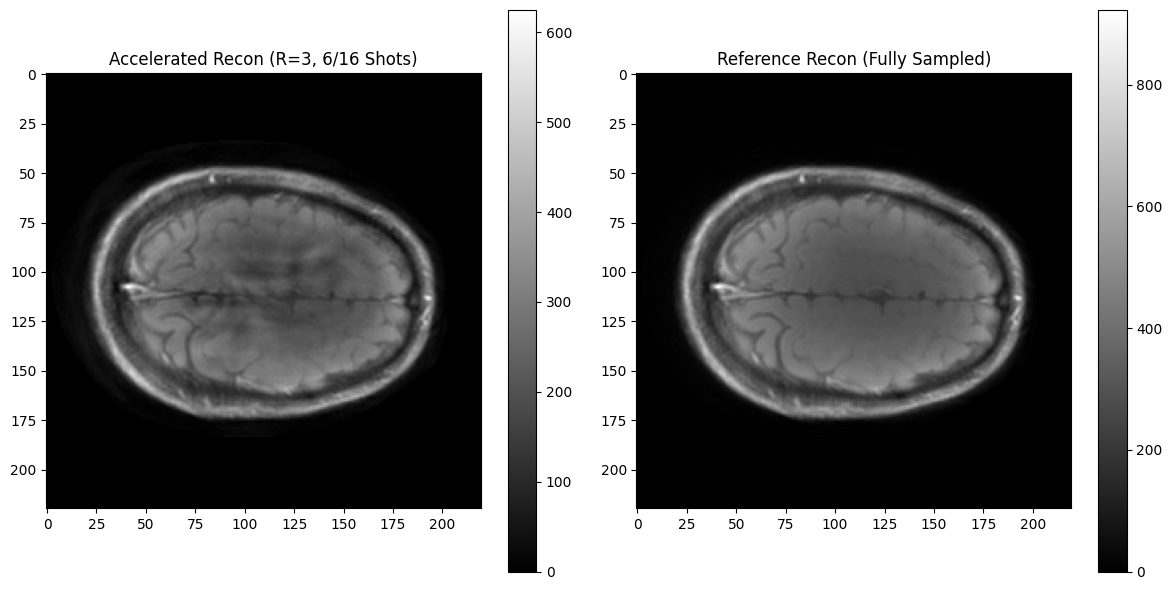


Calculating image quality metrics...
  PSNR vs Reference: 21.60 dB
  SSIM vs Reference: 0.9153


In [59]:
# --- 5) Reconstruct Accelerated and Reference Data ---
print(f"\nStarting reconstruction for R={R} (Accelerated)...")
# Reconstruction parameters (tune as needed)
max_iter = 100
lamda_l2 = 1e-1  # May need adjustment depending on R
max_eigen = 1  # Consider estimating this via power iteration for better convergence
tol = 1e-2

# --- Reconstruct Accelerated Data ---
recon_acc = True # Initialize
try:
    # Use the accelerated k-space (ksp_acc) and the corresponding operator (A_acc)
    recon_acc = CG_SENSE_recon(
        A_acc,                 # Use the SENSE operator created for accelerated data
        ksp_acc,               # Use the measured *undersampled* and *reshaped* k-space
        max_iter=max_iter,     # Pass max_iter correctly
        lamda_l2=lamda_l2,     # Pass lamda_l2 correctly
        max_eigen=max_eigen,   # Pass max_eigen correctly
        verbose=True,           # Keep verbose=True to monitor convergence
        tolerance=tol
    )
    print("Accelerated reconstruction finished.")
except NameError:
    print("Error: Reconstruction function (CG_SENSE_recon) not found.")
except Exception as e:
    print(f"An error occurred during accelerated reconstruction: {e}")

# --- Reconstruct Reference (Fully Sampled) Data ---
print("\nStarting reconstruction for Reference (Fully Sampled)...")
recon_ref = None # Initialize
try:
    # Use the fully sampled k-space (ksp_torch_full_flat) and the corresponding operator (A)
    recon_ref = CG_SENSE_recon(
        A,                     # Use the SENSE operator created for fully sampled data
        ksp_torch_full_flat,   # Use the measured *fully sampled* and *reshaped* k-space
        max_iter=max_iter,     # Pass max_iter correctly
        lamda_l2=lamda_l2,     # Pass lamda_l2 correctly (consider if different lambda needed for ref)
        max_eigen=max_eigen,   # Pass max_eigen correctly
        verbose=True,           # Keep verbose=True to monitor convergence
        tolerance=tol
    )
    print("Reference reconstruction finished.")
except NameError:
    print("Error: Reconstruction function (CG_SENSE_recon) not found.")
except Exception as e:
    print(f"An error occurred during reference reconstruction: {e}")


# --- 6) Visualize or save the results ---
print("\nDisplaying reconstructions...")

# Import metrics functions (ensure skimage is installed: pip install scikit-image)
try:
    from skimage.metrics import peak_signal_noise_ratio, structural_similarity
except ImportError:
    print("Warning: scikit-image not found. Cannot calculate PSNR/SSIM.")
    print("Install it using: pip install scikit-image")
    peak_signal_noise_ratio = None
    structural_similarity = None
import numpy as np # Ensure numpy is imported

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Create a figure with two subplots

recon_acc_np = None
recon_ref_np = None

# Display Accelerated Reconstruction
if recon_acc is not None:
    recon = recon_acc
    # Use .abs() for magnitude image if complex
    recon_acc_np = recon_acc.abs().cpu().numpy() if torch.is_complex(recon_acc) else recon_acc.cpu().numpy()
    try:
        title_acc = f"Accelerated Recon (R={R}, {num_shots_recon}/{num_shots_total} Shots)"
    except NameError:
        title_acc = f"Accelerated Recon (R={R})" # Fallback title
    im = axes[0].imshow(recon_acc_np, cmap="gray")
    axes[0].set_title(title_acc)
    fig.colorbar(im, ax=axes[0])
else:
    axes[0].set_title(f"Accelerated Recon (R={R}) - Failed/Skipped")
    axes[0].axis('off') # Hide axes if no image

# Display Reference Reconstruction
if recon_ref is not None:
    # Use .abs() for magnitude image if complex
    recon_ref_np = recon_ref.abs().cpu().numpy() if torch.is_complex(recon_ref) else recon_ref.cpu().numpy()
    title_ref = "Reference Recon (Fully Sampled)"
    im = axes[1].imshow(recon_ref_np, cmap="gray")
    axes[1].set_title(title_ref)
    fig.colorbar(im, ax=axes[1])
else:
    axes[1].set_title("Reference Recon - Failed/Skipped")
    axes[1].axis('off') # Hide axes if no image

plt.tight_layout()
plt.show()

# --- 7) Calculate and Display Metrics ---
if recon_acc_np is not None and recon_ref_np is not None and peak_signal_noise_ratio is not None:
    print("\nCalculating image quality metrics...")
    # Determine the data range from the reference image
    data_range = np.max(recon_ref_np) - np.min(recon_ref_np)

    if data_range == 0:
        print("  Warning: Reference image data range is zero. Cannot calculate metrics accurately.")
        psnr_val = float('inf') # Or handle as appropriate
        ssim_val = 1.0 # Images are identical if data range is 0
    else:
        # Ensure images are float type for SSIM calculation
        recon_ref_float = recon_ref_np.astype(np.float64)
        recon_acc_float = recon_acc_np.astype(np.float64)

        # Calculate PSNR
        psnr_val = peak_signal_noise_ratio(recon_ref_float, recon_acc_float, data_range=data_range)

        # Calculate SSIM
        # Use win_size=7 or another odd number < image size, common for medical images
        # Ensure window size is smaller than image dimensions
        win_size = min(7, recon_ref_float.shape[0] // 2 * 2 + 1, recon_ref_float.shape[1] // 2 * 2 + 1)
        if win_size < 3: win_size = 3 # Minimum required window size for SSIM might be 3 or more depending on skimage version

        ssim_val = structural_similarity(
            recon_ref_float,
            recon_acc_float,
            data_range=data_range,
            win_size=win_size,
            gaussian_weights=True # Often recommended
        )

    print(f"  PSNR vs Reference: {psnr_val:.2f} dB")
    print(f"  SSIM vs Reference: {ssim_val:.4f}")

elif recon_acc_np is None and recon_ref_np is None:
    print("\nBoth reconstructions failed or were skipped. Cannot calculate metrics.")
elif peak_signal_noise_ratio is None:
     print("\nSkipping metrics calculation because scikit-image is not installed.")
else:
    # Handle cases where only one reconstruction is available
    if recon_acc_np is None:
        print("\nAccelerated reconstruction failed or was skipped. Cannot calculate metrics.")
    if recon_ref_np is None:
        print("\nReference reconstruction failed or was skipped. Cannot calculate metrics.")


## Reconstruction

In [60]:
n_monte = 30
sigma = 1e-2
recon_acc = lambda ksp : CG_SENSE_recon(A_acc, ksp, max_iter, lamda_l2, max_eigen, verbose=False,tolerance=tol)
recon_ref = lambda ksp : CG_SENSE_recon(A, ksp, max_iter, lamda_l2, max_eigen, verbose=False,tolerance=tol)

start_time = time.time()
# var_PMR = calc_variance_PMR(R=recon_acc, ksp=ksp_acc,
#                           noise_var=sigma ** 2, n_replicas=n_monte, verbose=True)
g_PMR = gfactor_SENSE_PMR(R_ref=recon_ref,
                          R_acc=recon_acc,
                          ksp_ref=ksp_torch_full_flat*0,
                          ksp_acc=ksp_acc*0,
                          noise_var=sigma ** 2,
                          n_replicas=n_monte,
                          verbose=True)
end_time = time.time()
pmr_time = end_time - start_time
print(f"PMR with {n_monte} replicas took {pmr_time:.2f} seconds")







PMR Loop: 100%|██████████| 30/30 [00:00<00:00, 39.60it/s]

Near-zero indices: (tensor([  0,   0,   0,  ..., 219, 219, 219], device='cuda:0'), tensor([  0,   1,   2,  ..., 217, 218, 219], device='cuda:0'))
Values at near-zero indices in var_ref: tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Values at near-zero indices in var_acc: tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Min/Max var_ref: 0.0000e+00 / 4.2569e-01
Min/Max var_acc: 0.0000e+00 / 3.3856e-01
Min/Max ratio (var_acc / var_ref): 0.0000e+00 / 3.2396e+00
PMR with 30 replicas took 1.72 seconds


## Reference G-Factor

In [61]:
n_monte_ref = 100

# Measure time for reference method
start_time = time.time()
# var_ref = calc_variance_PMR(R=recon_acc, ksp=ksp_acc,
#                             noise_var=sigma ** 2, n_replicas=n_monte_ref, verbose=True)
g_ref = gfactor_SENSE_PMR(R_ref=recon_ref,
                          R_acc=recon_acc,
                          ksp_ref=ksp_torch_full_flat*0,
                          ksp_acc=ksp_acc*0,
                          noise_var=sigma ** 2,
                          n_replicas=n_monte_ref,
                          verbose=True)
end_time = time.time()
ref_time = end_time - start_time
print(f"Reference method with {n_monte_ref} replicas took {ref_time:.2f} seconds")

PMR Loop: 100%|██████████| 100/100 [00:02<00:00, 39.31it/s]

Near-zero indices: (tensor([  0,   0,   0,  ..., 219, 219, 219], device='cuda:0'), tensor([  0,   1,   2,  ..., 217, 218, 219], device='cuda:0'))
Values at near-zero indices in var_ref: tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Values at near-zero indices in var_acc: tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Min/Max var_ref: 0.0000e+00 / 3.8878e-01
Min/Max var_acc: 0.0000e+00 / 2.7597e-01
Min/Max ratio (var_acc / var_ref): 0.0000e+00 / 1.9274e+00
Reference method with 100 replicas took 5.64 seconds


## Our Method (directly estimate the diagonal of the covariance)

In [62]:
from mr_recon.recons import doubleCG_inv_op_builder

# Initialize reference and accelerated operators using the builder function
AHA_inv = doubleCG_inv_op_builder(
    A=A,  # Reference SENSE operator
    dcf=dcf_torch_full_flat,  # Reference DCF
    max_iter=max_iter,
    lamda_l2=lamda_l2,
    max_eigen=max_eigen,  # Will be estimated automatically
    tolerance=tol,
    verbose=False  # Show progress for eigenvalue estimation
)

AHA_inv_acc = doubleCG_inv_op_builder(
    A=A_acc,  # Accelerated SENSE operator
    dcf=dcf_acc,  # Accelerated DCF
    max_iter=max_iter,
    lamda_l2=lamda_l2,
    max_eigen=max_eigen,  # Will be estimated automatically
    tolerance=tol,
    verbose=False  # Show progress for eigenvalue estimation
)

In [63]:
# def AHA_inv_acc(x):
#     ret = conjugate_gradient(A_acc.normal, x, num_iters=max_iter, lamda_l2=lamda_l2, verbose=False,tolerance=1/scale)
#     ret = A_acc.adjoint(A_acc.forward(ret)*dcf_acc) # added dcf
#     ret = conjugate_gradient(A_acc.normal, ret, num_iters=max_iter, lamda_l2=lamda_l2, verbose=False,tolerance=1/scale)
#     return ret
# def AHA_inv(x):
#     ret = conjugate_gradient(A.normal, x, num_iters=max_iter, lamda_l2=lamda_l2, verbose=False,tolerance=1/scale)
#     ret = A.adjoint(A.forward(ret)*dcf_torch_full_flat) # added dcf
#     ret = conjugate_gradient(A.normal, ret, num_iters=max_iter, lamda_l2=lamda_l2, verbose=False,tolerance=1/scale)
#     return ret
scale = 1/tol
# AHA_inv_acc= lambda x : conjugate_gradient(A_acc.normal, x, num_iters=max_iter, lamda_l2=lamda_l2, verbose=False)
# AHA_inv= lambda x : conjugate_gradient(A.normal, x, num_iters=max_iter, lamda_l2=lamda_l2, verbose=False)
n_hutch=n_monte

# Measure time for our method
start_time = time.time()
# var_diag_comp = diagonal_estimator(M=AHA_inv_acc,inp_example=torch.zeros(im_size, device=torch_dev, dtype=torch.complex64),
#                                       n_replicas=n_hutch,rnd_vec_type='complex',sigma=sigma, verbose=True,scale=scale)
g_diag = gfactor_SENSE_diag(AHA_inv_ref=AHA_inv,
                                       AHA_inv_acc=AHA_inv_acc,
                                       inp_example=torch.zeros(im_size, device=torch_dev, dtype=torch.complex64),
                                       n_replicas=n_monte,
                                       sigma=sigma,
                                       rnd_vec_type='complex',
                                       verbose=True)
end_time = time.time()
diag_time = end_time - start_time
print(f"Our method with {n_hutch} replicas took {diag_time:.2f} seconds")


Diagonal Estimator Loop:  10%|█         | 3/30 [00:00<00:01, 20.45it/s]

norm of v: 2.1999998092651367
shape of v: torch.Size([220, 220])


Diagonal Estimator Loop:  10%|█         | 3/30 [00:00<00:01, 21.17it/s]

norm of v: 2.1999998092651367
shape of v: torch.Size([220, 220])


Diagonal Estimator Loop: 100%|██████████| 30/30 [00:01<00:00, 20.79it/s]

Our method with 30 replicas took 2.90 seconds


## Comparing All Methods

In [64]:
# --- Configuration ---
# Set this flag to True to compute and analyze 1/g factors, False to analyze g factors directly.
compute_inverse_g = False
# -------------------

# Check for NaNs before cleaning
print('g_ref before cleaning: contains NaNs =', torch.isnan(g_ref).any().item())
print('g_PMR before cleaning: contains NaNs =', torch.isnan(g_PMR).any().item())
print('g_diag before cleaning: contains NaNs =', torch.isnan(g_diag).any().item())

# Replace NaN values with 1.0 (avoids errors and maps NaN g-factor to 1/g=1 if inverted)
g_ref = torch.nan_to_num(g_ref, nan=1.0)
g_PMR = torch.nan_to_num(g_PMR, nan=1.0)
g_diag = torch.nan_to_num(g_diag, nan=1.0)

if compute_inverse_g:
    # #set 0s to 1
    g_ref[g_ref == 0] = 1
    g_PMR[g_PMR == 0] = 1
    g_diag[g_diag == 0] = 1
    # # Convert to 1/g factors and use new variable names
    inv_g_ref = 1 / g_ref
    inv_g_PMR = 1 / g_PMR
    inv_g_diag = 1 / g_diag

    # Print statistics for 1/g factors
    print('\n--- Statistics for 1/g factors ---')
    print('inv_g_ref (cleaned): mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}'.format(inv_g_ref.mean(), inv_g_ref.std(), inv_g_ref.max(), inv_g_ref.min()))
    print('inv_g_PMR (cleaned): mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}'.format(inv_g_PMR.mean(), inv_g_PMR.std(), inv_g_PMR.max(), inv_g_PMR.min()))
    print('inv_g_diag (cleaned): mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}'.format(inv_g_diag.mean(), inv_g_diag.std(), inv_g_diag.max(), inv_g_diag.min()))
    # #set value of 1 to 0
    inv_g_ref[inv_g_ref == 1] = 0
    inv_g_PMR[inv_g_PMR == 1] = 0
    inv_g_diag[inv_g_diag == 1] = 0

else:
    #set value of 1 to 0
    g_ref[g_ref == 1] = 0
    g_PMR[g_PMR == 1] = 0
    g_diag[g_diag == 1] = 0


# Print statistics after cleaning
print('g_ref (cleaned): mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}'.format(g_ref.mean(), g_ref.std(), g_ref.max(), g_ref.min()))
print('g_PMR (cleaned): mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}'.format(g_PMR.mean(), g_PMR.std(), g_PMR.max(), g_PMR.min()))
print('g_diag (cleaned): mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}'.format(g_diag.mean(), g_diag.std(), g_diag.max(), g_diag.min()))






g_ref before cleaning: contains NaNs = False
g_PMR before cleaning: contains NaNs = False
g_diag before cleaning: contains NaNs = True
g_ref (cleaned): mean = 0.5239, std = 0.5329, max = 1.3883, min = 0.0000
g_PMR (cleaned): mean = 0.5289, std = 0.5444, max = 1.7999, min = 0.0000
g_diag (cleaned): mean = 0.5274, std = 0.5398, max = 1.8515, min = 0.0000


Time for Reference (MC): 5.64 seconds
Time for Monte Carlo: 1.72 seconds
Time for Hutchinson's: 2.90 seconds
=== Similarity Metrics ===
NRMSE % (Analytical vs. Monte Carlo): 11.4587
Pearson Correlation (Analytical vs. Monte Carlo): 7.8038

NRMSE % (Analytical vs. Hutchinson's): 9.9143
Pearson Correlation (Analytical vs. Hutchinson's): 6.8873

SSIM (Analytical vs. Monte Carlo): 0.5584
SSIM (Analytical vs. Hutchinson's): 0.5688


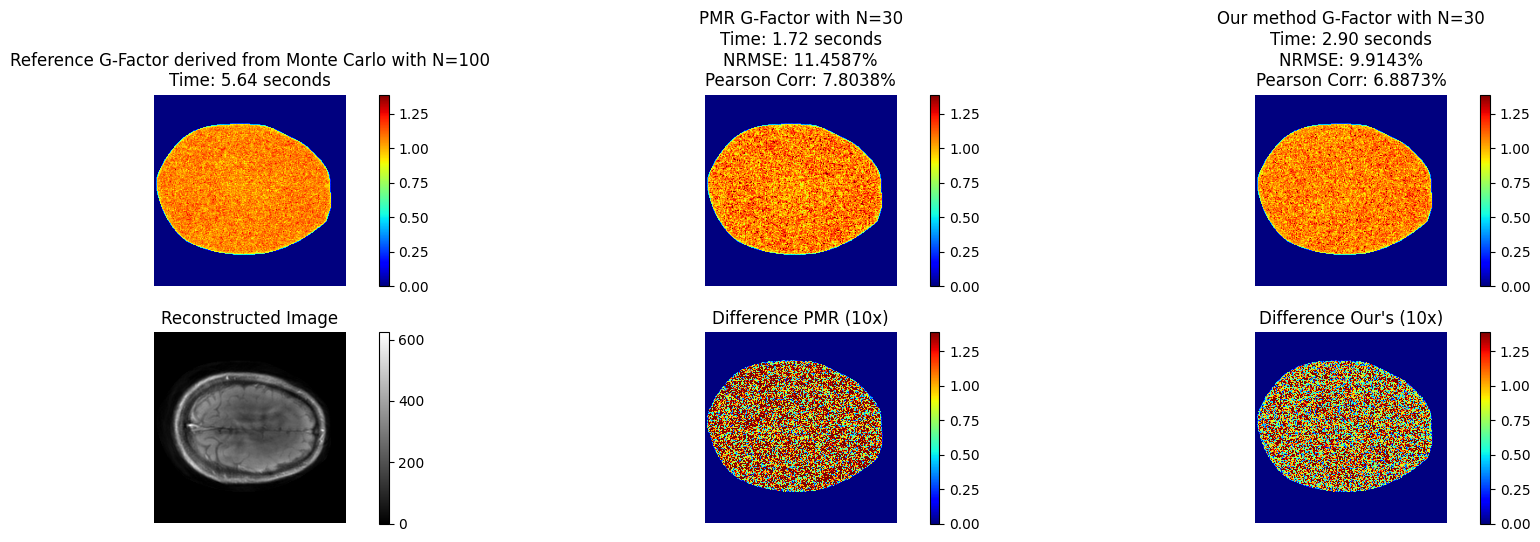

In [65]:
from mr_recon.iqa import compare_g_factors
if compute_inverse_g:
    compare_g_factors(inv_g_ref, inv_g_PMR, inv_g_diag, n_monte=n_monte,n_monte_ref=n_monte_ref, time_g=ref_time, time_monte=pmr_time, time_hutch=diag_time, plot=True, recon_image=recon)
else:
    compare_g_factors(g_ref, g_PMR, g_diag, n_monte=n_monte,n_monte_ref=n_monte_ref, time_g=ref_time, time_monte=pmr_time, time_hutch=diag_time, plot=True, recon_image=recon)